In [ ]:
# 250325

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from matplotlib.dates import date2num, DateFormatter, MonthLocator
import datetime
from glob import glob
import pandas as pd
import os

plot_path = ".plot"
anal_path = r'../2_analyze'
df_model_info = pd.read_csv(r"../0_data/model_info.csv", index_col=0)

df_mean = pd.read_csv(fr'{anal_path}/.out/mean_merged.csv', index_col=0)
df_model_info_merged = pd.concat([df_mean, df_model_info], axis=1)
df_model_info_merged = df_model_info[(df_model_info['Dist'] == 1)]
# df_model_info_merged

In [ ]:
df_ref = pd.read_csv(r'../0_data/reference.csv', index_col=0)
df_score = pd.read_csv(fr'{anal_path}/.out/mean_eng.csv', index_col=0)

#####################

df = pd.DataFrame()
df['Name'] = df_model_info_merged['Abb name']
df['mean'] = df_score.loc[df_model_info_merged.index, 'rate']
df['SD'] = df_score.loc[df_model_info_merged.index, 'SD']
df['Update'] = df_model_info_merged['Date']
df.reset_index(drop=True)
df.set_index('Name', inplace=True)

df.loc['Reference'] = df_ref.loc['Total'].tolist() + ['None']
df=df.sort_values(by='Update', ascending=False)
df=df.transpose()
df

#####################

dfs = {}
for subject in range(1, 5):
    df_sub = df_ref.loc[str(subject)].to_frame().transpose()
    df_sub.index = ['Reference']
    dfs[subject] = df_sub

indexes = df_model_info_merged.index
for i in indexes:
    path = glob(fr"{anal_path}/.subjects/{i}*eng]/analysis_40.csv")[0]
    df_score = pd.read_csv(path, index_col=0)
    df_score['Year'] = df_score.index.str[:4]
    df_score['Subject'] = df_score.index.str[-1]
    df_score['Year'] = df_score['Year'].astype(int)
    df_score['Subject'] = df_score['Subject'].astype(int)
    subject_stats = df_score.groupby('Subject')['rate'].agg(['mean', 'std']).rename(columns={'mean': 'mean', 'std': 'SD'})
    
    for subject in range(1, 5):
        temp_subject = subject_stats.loc[subject].to_frame().transpose()
        temp_subject.index = [i]
        dfs[subject] = pd.concat([dfs[subject], temp_subject])

for subject in range(1, 5):
    df_sub = dfs[subject]
    df_sub['Name'] = df_model_info_merged['Abb name']
    df_sub.loc['Reference', 'Name'] = 'Reference'
    df_sub['Update'] = df_model_info_merged['Date']
    df_sub.reset_index(drop=True, inplace=True)
    df_sub.set_index('Name', inplace=True)
    df_sub.loc['Reference', 'Update'] = 'None'
    df_sub = df_sub.sort_values(by='mean', ascending=True)
    df_sub = df_sub.sort_values(by='Update', ascending=False)
    dfs[subject] = df_sub.transpose()

df_1 = dfs[1]
df_2 = dfs[2]
df_3 = dfs[3]
df_4 = dfs[4]

In [ ]:
group_1_models = ['Llama 3 70B', 'MoMo 72B', 'Qwen 72B', 'SOLAR 0 70B', 'Llama 2 70B']
group_2_models = ['Claude 3.5 Sonnet', 'GPT-4o', 'Claude 3 Opus', 'Gemini 1.5 Pro', 'GPT-3.5 Turbo','PaLM 2 Unicorn','PaLM 2 Bison']
group_3_models = ['Gemini 1.0 Pro*', 'GPT-4*', 'GPT-4 Turbo*', 'GPT-3.5 Turbo*', 'Claude 3 Sonnet*']

red_palette = plt.get_cmap('RdYlGn')(np.linspace(0.15, 0.3, len(group_1_models)))
blue_palette = plt.get_cmap('YlGnBu')(np.linspace(0.75, 0.45, len(group_2_models)))
grey_palette = plt.get_cmap('Greys')(np.linspace(0.5, 0.5, len(group_3_models)))

def select_color(model_name):
    if model_name in group_1_models:
        return red_palette[group_1_models.index(model_name)]
    elif model_name in group_3_models:
        return grey_palette[group_3_models.index(model_name)]
    else:
        return blue_palette[group_2_models.index(model_name)]

def plot(df_input, plot_name, x_range, cutline, prob=[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5 ,0.6, 0.7, 0.8, 0.9, 0.95, 0.99,]):
    ref_mean = df_input.loc['mean', 'Reference']
    ref_sd = df_input.loc['SD', 'Reference']

    models_sorted_by_mean = df_input.loc['mean', :].drop('Reference').sort_values()

    x = np.linspace(ref_mean - 5*ref_sd, ref_mean + 4*ref_sd, 100)
    y = norm.pdf(x, ref_mean, ref_sd)

    update_dates = pd.to_datetime(df_input.loc['Update', :].drop('Reference'))

    dates_num = date2num(update_dates)

    fig, ax1 = plt.subplots(figsize=(7.5, 6))

    ax1.plot(x, y, label='Reference Normal Distribution', color='silver')
    ax1.set_xlabel('Score')

    ax1.set_ylabel('Density')
    ax1.tick_params(axis='y')
    ax1.set_ylim(0, None)
    ax1.set_xlim(x_range)

    ax2 = ax1.twinx()
    ax2.set_ylabel('Release Date')
    ax2.tick_params(axis='y')

    ax2.yaxis.set_major_formatter(DateFormatter('%Y-%m'))
    ax2.yaxis.set_major_locator(MonthLocator())

    plt.axvline(x=cutline, color='grey', linestyle='--', alpha=0.5, linewidth=0.5)
    plt.axvline(x=ref_mean, color='grey', linestyle='-', alpha=0.5, linewidth=1)

    for model in df_input.columns[1:]:
        mean = float(df_input.loc['mean', model])
        sd = float(df_input.loc['SD', model])
        date = dates_num[df_input.columns.get_loc(model)-1]
        color = select_color(model)
        ax2.errorbar(mean, date, xerr=sd, fmt='o', capsize=5, color=color)
        if model in ['Qwen 72B', 'Claude 3 Opus', 'MoMo 72B']:
            ax2.text(mean, date - 12, model, color=color, ha='center', va='bottom')
        else:
            ax2.text(mean, date + 2, model, color=color, ha='center', va='bottom')

    ax3 = ax1.twiny()

    prob = prob
    
    x_ticks = norm.ppf(prob, ref_mean, ref_sd)

    # Set the new X-axis limits and labels
    ax3.set_xlim(ax1.get_xlim())
    ax3.set_xticks(x_ticks)
    ax3.set_xticklabels([f'{(1-p):.0%}' for p in prob])
    # ax3.set_xlabel('Cumulative Probability')

    ax3.tick_params(axis='x', labelsize=8)

    start_date = date2num(datetime.datetime(2023, 6, 1))
    end_date = date2num(datetime.datetime(2024, 7, 10))
    ax2.set_ylim(start_date, end_date)

    fig.tight_layout()
    if not os.path.exists(plot_path):
        os.makedirs(plot_path)
    plt.savefig(f'{plot_path}/{plot_name}.pdf', bbox_inches='tight', format='pdf')
    plt.show()

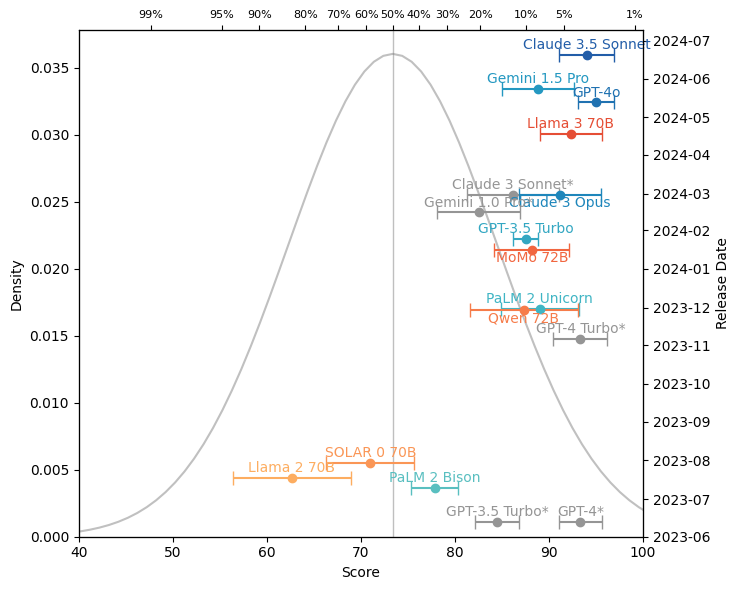

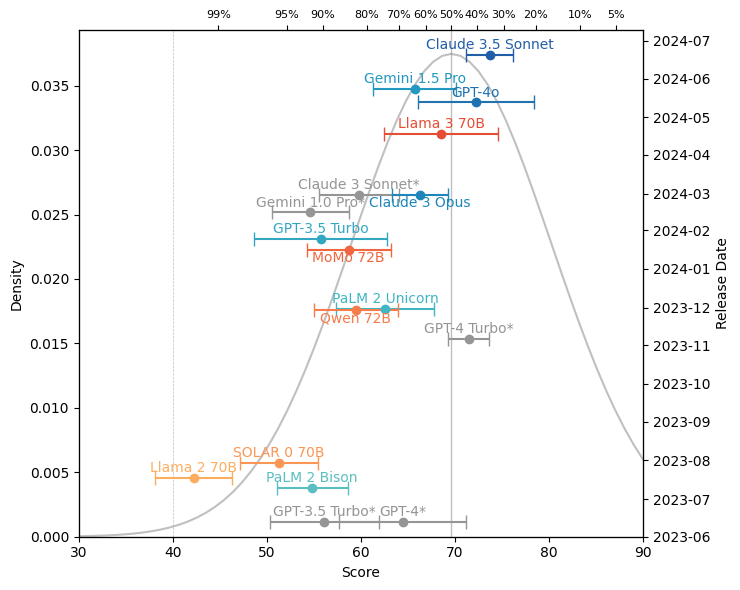

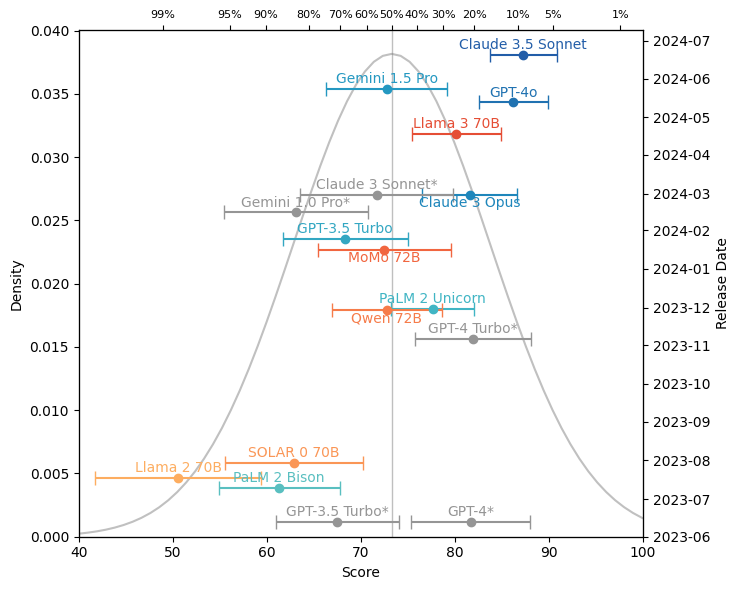

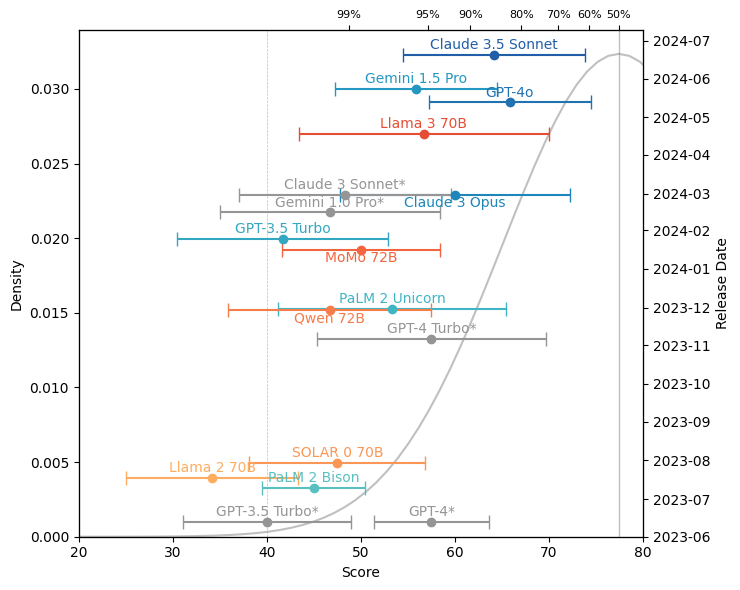

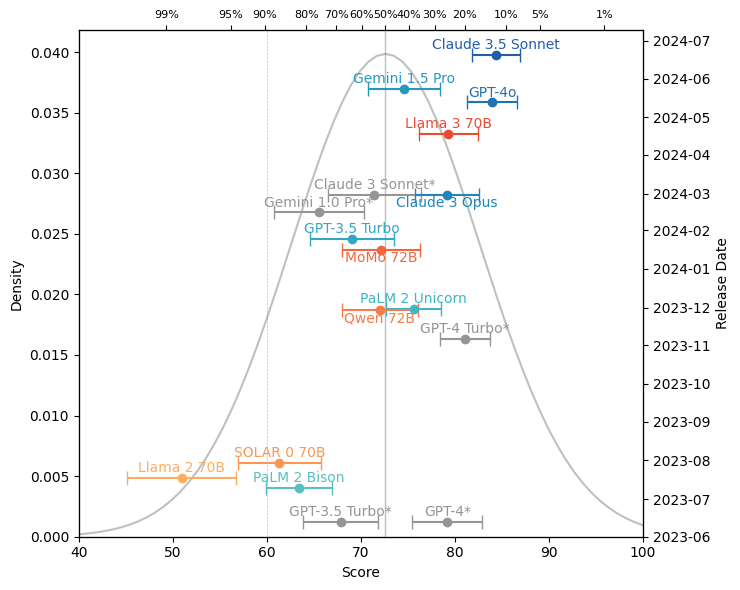

In [4]:
prob2=[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5 ,0.6, 0.7, 0.8, 0.9, 0.95,]
prob4=[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5 ]
plot(df_1, "2-dist_over_time_1", cutline=40, x_range=(40, 100))
plot(df_2, "2-dist_over_time_2", cutline=40, x_range=(30, 90), prob=prob2)
plot(df_3, "2-dist_over_time_3", cutline=40, x_range=(40, 100))
plot(df_4, "2-dist_over_time_4", cutline=40, x_range=(20, 80), prob=prob4)
plot(df, "2-dist_over_time_all", cutline=60, x_range=(40, 100))

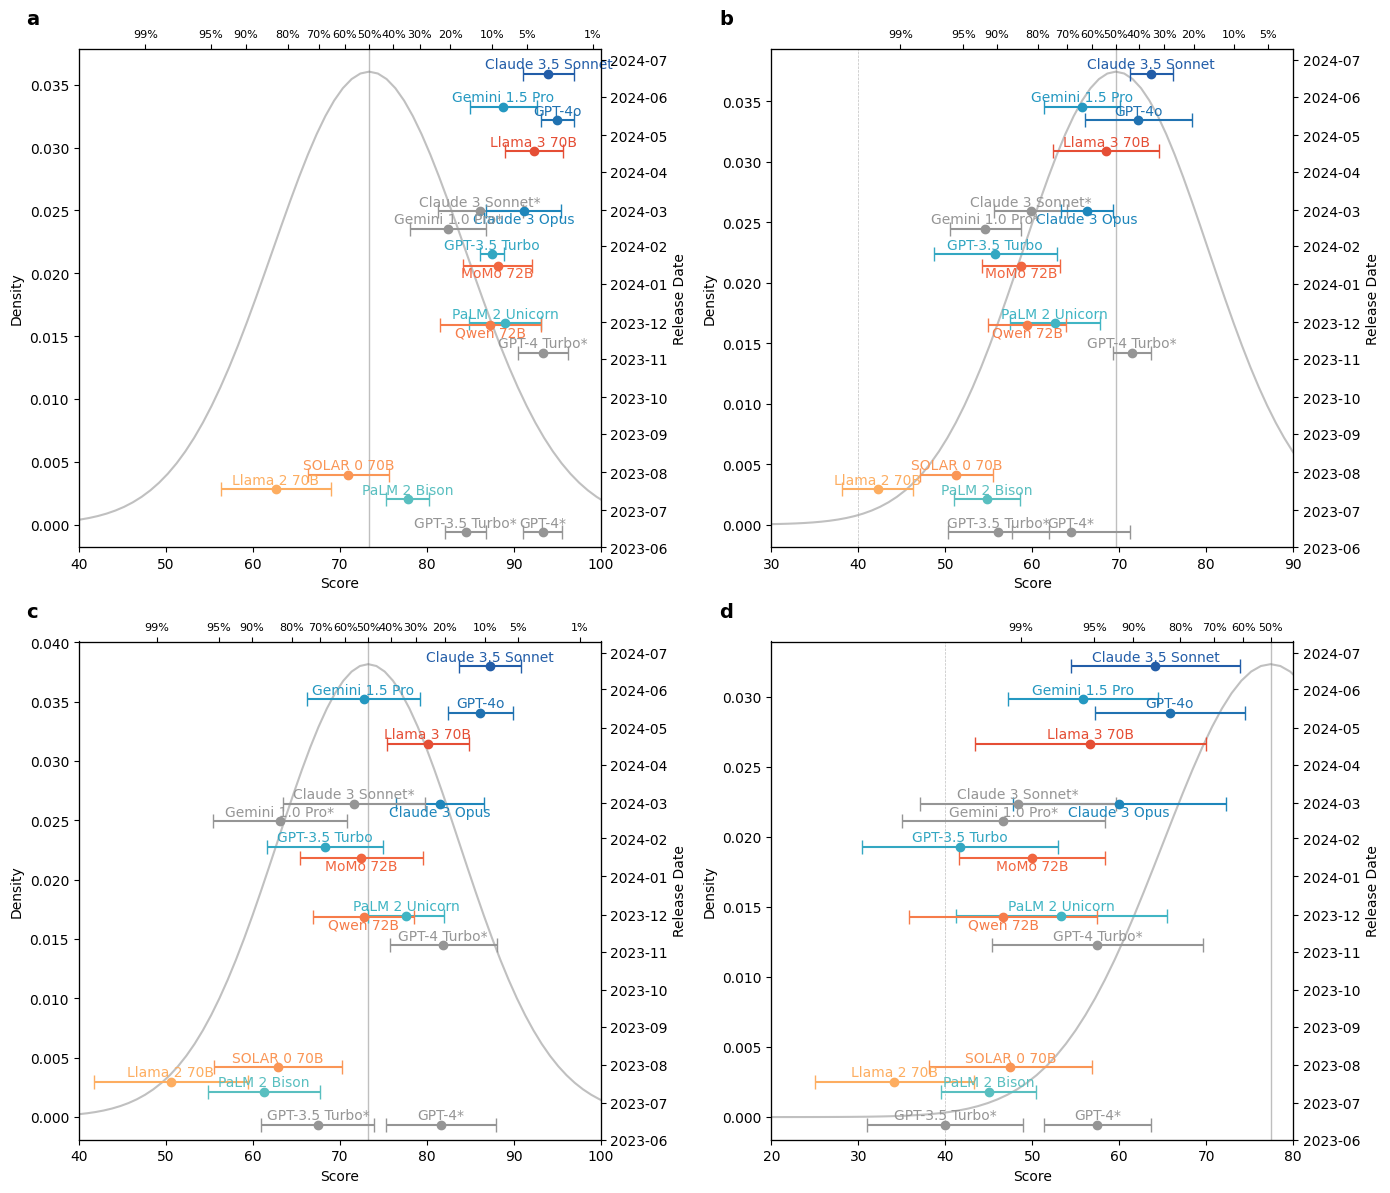

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

def plot_subplot(ax, df_input, plot_name, x_range, cutline, prob):
    ref_mean = df_input.loc['mean', 'Reference']
    ref_sd = df_input.loc['SD', 'Reference']
    x = np.linspace(ref_mean - 5*ref_sd, ref_mean + 4*ref_sd, 100)
    y = norm.pdf(x, ref_mean, ref_sd)

    update_dates = pd.to_datetime(df_input.loc['Update', :].drop('Reference'))
    dates_num = date2num(update_dates)

    ax.plot(x, y, label='Reference', color='silver')
    ax.set_xlabel('Score')
    ax.set_ylabel('Density')
    ax.set_xlim(x_range)

    ax2 = ax.twinx()
    ax2.set_ylabel('Release Date')
    ax2.yaxis.set_major_formatter(DateFormatter('%Y-%m'))
    ax2.yaxis.set_major_locator(MonthLocator())

    ax.axvline(x=cutline, color='grey', linestyle='--', alpha=0.5, linewidth=0.5)
    ax.axvline(x=ref_mean, color='grey', linestyle='-', alpha=0.5, linewidth=1)

    for model in df_input.columns[1:]:
        mean = float(df_input.loc['mean', model])
        sd = float(df_input.loc['SD', model])
        date = dates_num[df_input.columns.get_loc(model)-1]
        color = select_color(model)
        ax2.errorbar(mean, date, xerr=sd, fmt='o', capsize=5, color=color)

        if model in ['Qwen 72B', 'Claude 3 Opus', 'MoMo 72B']:
            ax2.text(mean, date - 12, model, color=color, ha='center', va='bottom')
        else:
            ax2.text(mean, date + 2, model, color=color, ha='center', va='bottom')
    ax3 = ax.twiny()
    x_ticks = norm.ppf(prob, ref_mean, ref_sd)
    ax3.set_xlim(ax.get_xlim())
    ax3.set_xticks(x_ticks)
    ax3.set_xticklabels([f'{(1-p):.0%}' for p in prob], fontsize=8)

    start_date = date2num(datetime.datetime(2023, 6, 1))
    end_date = date2num(datetime.datetime(2024, 7, 10))
    ax2.set_ylim(start_date, end_date)
prob=[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5 ,0.6, 0.7, 0.8, 0.9, 0.95, 0.99,]

plot_subplot(axes[0], df_1, "2-dist_over_time_1", (40, 100), 40, prob)
axes[0].text(-0.1, 1.05, 'a', transform=axes[0].transAxes, weight='bold', fontsize=14)

plot_subplot(axes[1], df_2, "2-dist_over_time_2", (30, 90), 40, prob2)
axes[1].text(-0.1, 1.05, 'b', transform=axes[1].transAxes, weight='bold', fontsize=14)

plot_subplot(axes[2], df_3, "2-dist_over_time_3", (40, 100), 40, prob)
axes[2].text(-0.1, 1.05, 'c', transform=axes[2].transAxes, weight='bold', fontsize=14)

plot_subplot(axes[3], df_4, "2-dist_over_time_4", (20, 80), 40, prob4)
axes[3].text(-0.1, 1.05, 'd', transform=axes[3].transAxes, weight='bold', fontsize=14)

plt.tight_layout()
if not os.path.exists(plot_path):
    os.makedirs(plot_path)
plt.savefig(f'{plot_path}/2-combined.pdf', bbox_inches='tight', format='pdf')
plt.show()